This script is based on Curved Origami by Ekaterina Likasheva. The terminology from that book is used to build generic tesselation style curves, obeying the rules (as I understand them) from the book. I suspect there is some additional mathematics that I am unaware of (but would be interested in knowing).

In [187]:
from math import *
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import collections  as mc
from matplotlib.patches import Ellipse, Wedge, Polygon
from matplotlib.path import Path
import matplotlib
import itertools

from scipy.spatial import distance
from scipy import signal


The system for the curved tesselation starts with a kernel-curve. It has specific properties detailed in the book but generally can be represented with most bell-shaped curves. 

The rest of the system is easier if you start only with the first half of the bell.

I'm using a Gaussian curve (normalized to the shape I want). I believe that generating different kernels by changing `curve_h_of_c` will lead to compatible curves for patterns such as Challenge in the book.

In [355]:
class curve_kernel():
  def __init__(self, angle = 60.0, horiz_d = 1.0, curve_h_of_c = 0.66, N=100, std=50):
    if (angle < 20.0) or (angle > 70.0): 
      print("WARNING: CAB angle {} should be between 20 and 70 degrees".format(angle))

    self.angle = angle;
    self.horiz_d = horiz_d
    self.curve_h_of_c = curve_h_of_c
    self.a = [0,0]
    self.mid = [horiz_d/2,0]
    self.c = [horiz_d/2, tan(radians(angle))*horiz_d/2]
    
    curve_x = np.arange(0, horiz_d,horiz_d/N)
    curve_y = signal.gaussian(N, std)
    curve_y -= min(curve_y)
    curve_y *= curve_h_of_c/max(curve_y) 
    self.curve = np.array([curve_x[0:floor(N/2)], curve_y[0:floor(N/2)]])
    self.offset = self.curve[0,-1] #+ horiz_d/N

  def __repr__(self):
    plt.plot(self.curve[0,:], self.curve[1,:])
    print("Distance a to c: {:2.2}".format(distance.euclidean(self.a, self.c)))
    return ("Angle {}, d {}, A {}, B {}, C {}".format(self.angle, self.horiz_d,
                                                    self.a, self.mid, self.c))

class curves():
  def __init__(self, kernel):
    self.kernel = kernel.curve
    self.offset = kernel.curve[0,-1]
    self.h      = max(kernel.curve[1,:])
    self.len    = 2*len(kernel.curve[1,:])

    self.a_curve = self.concatenate(first = self.kernel, 
                                    second = self.reverse(self.kernel))

    self.b_curve = self.concatenate(first = self.negative(self.reverse(self.kernel)), 
                                    second = self.kernel)

    c = self.yoffset(self.kernel, -self.h)
    self.c_curve = self.concatenate(first = c, 
                                    second = self.negative(self.reverse(c)))
    
  def yoffset(self, curve, offset):
    curve = np.copy(curve)
    curve[1,:] += offset
    return curve

  def negative(self, curve):
    curve = np.array([curve[0,:], -curve[1,:]])
    return curve

  def reverse(self, curve):
    curve = np.array([curve[0,:], np.flip(curve[1,:])])
    return curve

  def roll(self, curve, rollby):
    curve = np.copy(curve)
    curve[1,:] = np.roll(curve[1,:], rollby)
    return curve

  def concatenate(self, first, second):
    if first is None:
      return second
    xoffset = first[0,-1]
    second = np.copy(second)
    second[0,:] += xoffset
    return(np.concatenate((first, second), axis=1))

  def __repr__(self):
    plt.plot(self.kernel[0,:], self.kernel[1,:], 'k.')
    plt.plot(self.a_curve[0,:], self.a_curve[1,:], 'r')
    plt.plot(self.b_curve[0,:], self.b_curve[1,:], 'b')
    plt.plot(self.c_curve[0,:], self.c_curve[1,:], 'c')
    return ""


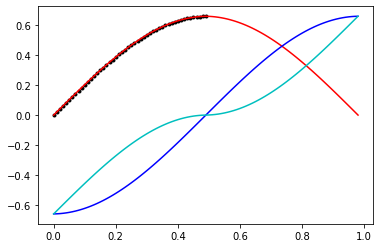

In [356]:
ckernel = curve_kernel(60.0)
cvs = curves(ckernel)
print(cvs)

I want to be able to use the Amanda Ghassaei's [Origami Simulator](https://origamisimulator.org/) to test the output of the script. 

In this next block, I'm fixing up the matplotlib output to be more compatible with the simulator.

In [357]:
indef = False
def rm_clippath(line):
  global indef

  if not indef:
    f = line.find('<clipPath')
  else:
    f = line.find('</clipPath>')
  if f >= 0:
    indef = not indef
    return ""
  if indef: return ""

  f = line.find('clip-path')
  if (f < 0): return line
  fc = line.find('"', f) + 1
  fe = line.find('"', fc) +1
  return line[:f]+line[fe:]

def fixup_svg(infile):
  global indef
  indef = False
  outfile = "kt_"+ infile
  delete_list = ['fill:none;']
  with open(infile) as fin, open(outfile, "w+") as fout:
    for line in fin:
      line = rm_clippath(line)
      for word in delete_list:
        line = line.replace(word, "")
      fout.write(line)


In [391]:
def curveNoneZero(curve):
  if curve is None: 
    curve = np.zeros((2,1))
  return curve

def A_curve(curve, cvs, mult):
  curve = curveNoneZero(curve)
  return cvs.concatenate(curve, mult*np.copy(cvs.a_curve))
def a_curve(curve, cvs, mult):
  curve = curveNoneZero(curve)
  return cvs.concatenate(curve, mult*cvs.yoffset(cvs.a_curve, -cvs.h))
def B_curve(curve, cvs, mult):
  curve = curveNoneZero(curve)
  return cvs.concatenate(curve, mult*np.copy(cvs.b_curve))
def b_curve(curve, cvs, mult):
  curve = curveNoneZero(curve)
  return cvs.concatenate(curve, mult*cvs.reverse(cvs.b_curve))
def C_curve(curve, cvs, mult):
  curve = curveNoneZero(curve)
  return cvs.concatenate(curve, mult*np.copy(cvs.c_curve))
def c_curve(curve, cvs, mult):
  curve = curveNoneZero(curve)
  return cvs.concatenate(curve, mult*cvs.reverse(cvs.c_curve))
def U_curve(curve, cvs, mult):
  curve = curveNoneZero(curve)
  return cvs.concatenate(curve, mult*cvs.negative(np.copy(cvs.a_curve)))
def u_curve(curve, cvs, mult):
  curve = curveNoneZero(curve)
  return cvs.concatenate(curve, mult*cvs.negative(cvs.yoffset(cvs.a_curve, -cvs.h)))


def pipe_curve(curve, cvs, mult):
  pipe = np.array([[0,0],[0,cvs.h]])
  return cvs.concatenate(curve, mult*pipe)

def blank_curve(curve, cvs, mult):
  xoffset = (cvs.a_curve[0,-1])*mult
  blank = np.array([[0, xoffset],[np.nan,np.nan]])
  return cvs.concatenate(curve, blank)

def rollhalf(cvs):
  return floor(cvs.len/2)

def color_red():
  return 'r-'
def color_blue():
  return 'b-'

interpret_curve = {
    "A"   : A_curve,
    "a"   : a_curve,
    "B"   : B_curve,
    "b"   : b_curve,
    "C"   : C_curve,
    "c"   : c_curve,
    "U"   : U_curve,
    "u"   : u_curve,
    
    "|"   : pipe_curve,
    "x"   : blank_curve
}

roll_control = {
    "o"   : rollhalf
}
height_control = {
    "h"   : rollhalf
}

colors = {
    "red" : color_red,
    "blue": color_blue,
}

def interpret_line(yoffset, line, cvs):
  elements = line.split()
  curve = None
  color = 'k'
  rollby = 0
  height = 1
  for e in elements:
    if e in roll_control:
      rollby = roll[e](cvs)
    elif e in colors:
      color = colors[e]()
    elif e[0] in height_control:
      height = float(e[1:]) * cvs.h
    elif e[0] in interpret_curve:
      mult = 1.0
      if len(e) > 1:
        mult = float(e[1:])
      curve = interpret_curve[e[0]](curve, cvs, mult)
  curve = cvs.roll(curve, rollby)
  curve = cvs.yoffset(curve, yoffset)
  plt.plot(curve[0,:], curve[1,:], color)
  return color, curve, height

def minmax(minxy, maxxy, curve):
  new_minxy = np.nanmin(curve, 1)
  new_maxxy = np.nanmax(curve, 1)
  minxy = np.nanmin(np.stack((minxy, new_minxy), 1),1)
  maxxy = np.nanmax(np.stack((maxxy, new_maxxy), 1),1)
  return minxy, maxxy

def plot_outer_box(minxy, maxxy, color='k'):
  plt.plot([minxy[0], minxy[0]], [minxy[1],maxxy[1]], color )
  plt.plot([maxxy[0], maxxy[0]], [minxy[1],maxxy[1]], color )
  plt.plot([minxy[0], maxxy[0]], [minxy[1],minxy[1]], color )
  plt.plot([minxy[0], maxxy[0]], [maxxy[1],maxxy[1]], color )



In [392]:
def interpret_tess(name, input, cvs):
  minxy = np.ones((2)) * nan
  maxxy = np.ones((2)) * nan
  yoffset = 0.0
  for line in input:
    color, curve, height = interpret_line(yoffset, line, cvs)
    minxy, maxxy = minmax(minxy, maxxy, curve)
    yoffset -= height
  plt.axis('off')
  plot_outer_box(minxy, maxxy, 'k')
  plt.savefig(name + ".svg")
  fixup_svg(name + ".svg")


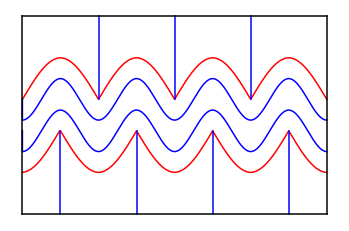

In [393]:
name = "testone2"

testone = [
    "red A2 A2 A2 A2 h0",
    "blue x2 |4 x2 |4 x2 |4 h0",
    "blue  B b B b B b B b",
    "blue  B b B b B b B b h0",
    "red o U2 U2 U2 U2 h0",
    "blue  x |-4 x2 |-4 x2 |-4 x2 |-4"
]

interpret_tess(name,testone, cvs)

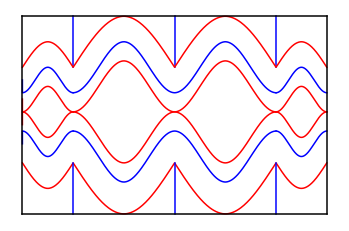

In [394]:
unevenwaves = [
    "blue x2 |4 x4 |4 x4 |4 h0",
    "red A2 A4 A4 A2 h0",

    "blue  x x B2 b2 B2 b2 x x h1",
    "blue  B b x2 x2 x2 x2 B b h0.5",

    "red  x x B2 b2 B2 b2 x x h1",
    "red  B b x2 x2 x2 x2 B b h2",

    "red   b B x2 x2 x2 x2 b B h1",
    "red  x x b2 B2 b2 B2 x x h0.5",

    "blue   b B x2 x2 x2 x2 b B h1",
    "blue  x x b2 B2 b2 B2 x x h0.5",

    "red U2 U4 U4 U2 h0",
    "blue x2 |-4 x4 |-4 x4 |-4 h0",
]
interpret_tess("unevenwaves",unevenwaves,cvs)

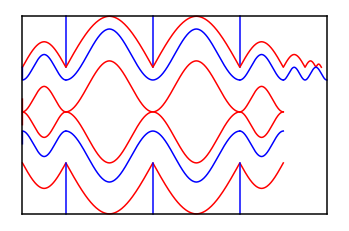

In [395]:
jellytwo = [
    "blue  x20 |40 x40 |40  x40 |40 h0",
    "red   A20     A40     A40     A20     A10 A5 A2.5 h-10.0",


    "blue  x10 x10 B20 b20 B20 b20 x10 x10 h10",
    "blue  B10 b10 x20 x20 x20 x20 B10 b10 h5",
    "blue  x10 x10 x20 x20 x20 x20 x10 x10 B5 b5 B5 b5 h10",

    "red  x10 x10 B20 b20 B20 b20 x10 x10 h10",
    "red  B10 b10 x20 x20 x20 x20 B10 b10 h20",

    "red   b10 B10 x20 x20 x20 x20 b10 B10 h10",
    "red   x10 x10 b20 B20 b20 B20 x10 x10 h5",

    "blue  b10 B10 x20 x20 x20 x20 b10 B10 h10",
    "blue  x10 x10 b20 B20 b20 B20 x10 x10 h5",

    "red U20 U40 U40 U20 h0",
    "blue x20 |-40 x40 |-40 x40 |-40 h0",
]
interpret_tess("jellytwo",jellytwo, cvs)

In [396]:
curve 

array([[ 0.  ,  0.98,  0.98,  0.98,  0.98,  2.94,  2.94,  2.94,  2.94,
         4.9 ,  4.9 ,  4.9 ,  4.9 ,  6.86,  6.86,  6.86],
       [  nan,   nan, -1.98, -4.62,   nan,   nan, -1.98, -4.62,   nan,
          nan, -1.98, -4.62,   nan,   nan, -1.98, -4.62]])